In [1]:
import numpy as np
import pandas as pd

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

# From https://github.com/rhayman/ephysiopy
from ephysiopy.common.gridcell import SAC


%load_ext autoreload
%autoreload 2

# sns.set_style("ticks")
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# Content of data frame:
# 'session_id': Unique ID of the recording session. The trajectory data will be the same for all cells that have the same session_id
# It consists of the animal_id (M0, M1...), date, and session type (open field)
# 'cluster_id': Unique ID of cell *within* the session. (session_id + cluster_id together are a unique ID for a cell in the entire data set)
# 'position_x': Position of animal (x coordinate) when the cell fired. Corresponds to position_y, hd and firing_times
# 'position_y': Position of animal (y coordinate) when the cell fired.
# 'hd': Head direction of animal when the cell fired.
# 'firing_maps': Firing rate map of cell.
# 'firing_times': Times when cell fired.
# 'trajectory_hd': Head direction from the trajectory of the animal.
# 'trajectory_x': x coordinate of the trajectory of the animal.
# 'trajectory_y': y coordinate of the trajectory of the animal.
# 'trajectory_times': sampling times of the trajectory of the animal. (~30 samples / sec frame rate).

In [3]:
fp_data = '/mnt/807ADEB67ADEA7E4/GerleiMice/SORTED_CLUSTERS/sorted_clusters.pkl'

In [4]:
data = pd.read_pickle(fp_data)

In [ ]:
data.head()

In [8]:
# Get ratemaps in same shape
all_rm = data.iloc[:,5]
all_rm_padded = np.array([np.pad(x, ((42-x.shape[0], 0), (43-x.shape[1], 0))) for x in all_rm])[...,2::,3::]

In [9]:
all_rm_padded.shape

(375, 40, 40)

In [ ]:
plt.plot(data.iloc[4,6], '.')
plt.show()

In [ ]:
plt.plot(data.iloc[0,2], data.iloc[0,3])
plt.show()

In [ ]:
plt.matshow(data.iloc[92,5], aspect='auto')
plt.show()

In [ ]:
data.shape

In [ ]:
plt.matshow(np.median(all_rm_padded, axis=0))
plt.show()

In [ ]:
plt.matshow(np.mean(all_rm_padded, axis=0))
plt.show()

In [ ]:
plt.matshow(all_rm[0], aspect='auto')
plt.show()

In [28]:
grid_scores = []
for rmp in all_rm:
    S = SAC()
    basic_ratemap = rmp
    nodwell = ~np.isfinite(basic_ratemap)
    sac = S.autoCorr2D(basic_ratemap, nodwell)
    measures = S.getMeasures(sac)
    
    grid_scores.append(measures['gridness'])
grid_scores = np.array(grid_scores)

/home/marx/miniconda3/envs/hackathon/lib/python3.8/site-packages/ephysiopy/common/ephys_generic.py:2207: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  peaksMask = feature.peak_local_max(
/home/marx/miniconda3/envs/hackathon/lib/python3.8/site-packages/ephysiopy/common/binning.py:638: RuntimeWarning: divide by zero encountered in true_divide
  mapCovar / mapStd / mapStd[::-1, :, :][:, ::-1, :][:, :, :])


In [29]:
grid_scores = np.array(grid_scores)

In [32]:
plt.plot(grid_scores)
plt.show()

<IPython.core.display.Javascript object>

In [40]:
np.argsort(grid_scores)[::-1]

array([ 72,  74, 290, 298, 158, 122,  96, 284,  97, 179,  76, 302, 171,
       103, 102, 250, 264, 297, 227, 256, 294, 170, 286, 358, 166, 346,
       195, 237, 280, 228, 268, 253, 289,  95, 271,  23, 239, 130, 273,
       283,  99, 367, 197, 345, 269, 285, 230, 328,  40, 332, 291, 231,
       223, 168, 263, 353, 159, 295, 167, 127, 148, 317, 369, 110,  51,
       164,  28, 338,  78,  38, 160, 118, 326, 267, 311, 238,  12, 292,
       315, 131, 272, 296, 322, 252,  50, 329, 178, 135, 134, 144, 314,
       104, 255, 208, 163, 198, 299, 114,   2, 143, 115, 150, 261, 176,
       248, 105,  55, 182, 293,  61, 301, 305,  83, 213, 276, 172, 287,
       344, 259, 265, 117, 155,  11, 100, 190,  85, 142, 113, 235, 120,
       247,  22, 121, 324,  80, 153, 243, 333, 129, 245,  98, 125, 194,
       339, 154,   6,  36,  81,  89, 303, 186, 224, 236,  64, 109,  35,
       321, 251,  88, 220, 123, 169, 240, 364,  57,   8, 112,  30, 152,
       304, 215, 225, 343,  42,  17, 244, 363, 318, 183, 334,  8

<IPython.core.display.Javascript object>


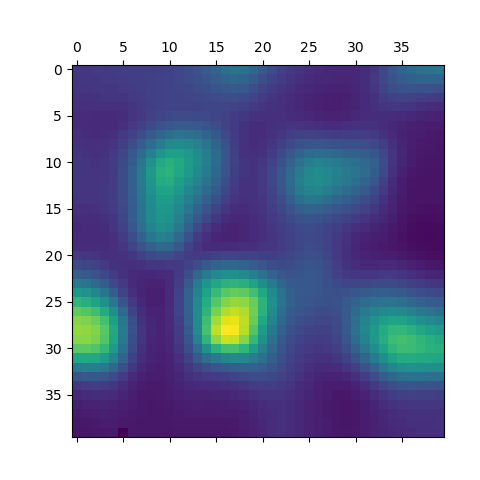

In [46]:
plt.matshow(all_rm_padded[76,:], aspect='auto')
plt.show()

In [34]:
grid_scores[74]

1.2562043672361953